In [1]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /home/linhle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Dataset

In [2]:
!gdown 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q -O data.zip
!unzip data.zip 
!rm data.zip

Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /mnt/d/AIO2024/homework/AIO2024_Exercises/module06/week03_RNN/data.zip
100%|████████████████████████████████████████| 230k/230k [00:00<00:00, 1.78MB/s]
Archive:  data.zip
   creating: dataset/
  inflating: dataset/all-data.csv    


In [2]:
headers = ["sentiment", "content"]
df = pd.read_csv("dataset/all-data.csv", names=headers, encoding="ISO-8859-1")
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
classes = {class_name: idx for idx, class_name in enumerate(df["sentiment"].unique().tolist())}
df["sentiment"] = df["sentiment"].apply(lambda x: classes[x])
df.head()

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


## Preprocessing

In [4]:
english_stop_words = stopwords.words("english")
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r"[^\w\s]", "", text)
    text = " ".join([word for word in text.split(" ") if word not in english_stop_words])
    text = " ".join([stemmer.stem(word) for word in text.split(" ")])
    return text

df["content"] = df["content"].apply(lambda x: text_normalize(x))
df.head()

,sentiment,content
0,0,accord gran compani plan move product russia ...
1,0,technopoli plan develop stage area less 100000...
2,1,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year 20092012 b...


### Build Vocab

In [5]:
vocab = []
for sentence in df["content"]:
    tokens = sentence.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append("UNK")
vocab.append("PAD")

word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)
vocab_size

8908

In [6]:
list(word_to_idx.items())[:5]

[('accord', 0), ('gran', 1), ('compani', 2), ('plan', 3), ('move', 4)]

In [7]:
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            tokens.append(word_to_idx[w])
        except KeyError:
            tokens.append(word_to_idx["UNK"])
    
    if len(tokens) < max_seq_len:
        tokens += [word_to_idx["PAD"]] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]
    return tokens

### Train Val Test Split

In [8]:
texts = df["content"].tolist()
labels = df["sentiment"].tolist()

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=0.2,
    random_state=seed,
    shuffle=True
)

len(X_train), len(X_val), len(y_train), len(y_val)

(3876, 970, 3876, 970)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=0.125,
    random_state=seed,
    shuffle=True
)

len(X_train), len(X_test), len(y_train), len(y_test)

(3391, 485, 3391, 485)

### Pytorch Datasets

In [11]:
class FinancialNews(Dataset):
    def __init__(self, X, y, word_to_idx, max_seq_len, transform=None):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        if self.transform:
            text = self.transform(
                text,
                self.word_to_idx,
                self.max_seq_len
            )
        text = torch.tensor(text)
        return text, label

### DataLoader

In [12]:
train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=32,
    transform=transform
)
val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=32,
    transform=transform
)
test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=32,
    transform=transform
)

len(train_dataset), len(val_dataset), len(test_dataset)

(3391, 970, 485)

In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False
)

len(train_loader), len(val_loader), len(test_loader)

(27, 122, 61)

## RNN

In [14]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [15]:
n_classes = len(classes.keys())
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=64,
    hidden_size=64,
    n_layers=2,
    n_classes=n_classes,
    dropout_prob=0.2
).to(device)

In [16]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    for epoch in range(epochs):
        # Training phase
        batch_train_losses = []
        correct, total = 0, 0
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_train_losses.append(loss.item())
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = sum(batch_train_losses) / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(
            f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%"
        )
    return train_losses, train_accs, val_losses, val_accs


def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    loss = np.mean(losses) 
    acc = 100 * correct / total
    return loss, acc

In [18]:
train_losses, train_accs, val_losses, val_accs = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

Epoch 1/50 | Train Loss: 1.0059, Train Accuracy: 57.86% | Val Loss: 0.9538, Val Accuracy: 58.76%
Epoch 2/50 | Train Loss: 0.9443, Train Accuracy: 59.22% | Val Loss: 0.9328, Val Accuracy: 58.76%
Epoch 3/50 | Train Loss: 0.9317, Train Accuracy: 59.22% | Val Loss: 0.9292, Val Accuracy: 58.76%
Epoch 4/50 | Train Loss: 0.9334, Train Accuracy: 59.19% | Val Loss: 0.9286, Val Accuracy: 58.76%
Epoch 5/50 | Train Loss: 0.9265, Train Accuracy: 59.19% | Val Loss: 0.9285, Val Accuracy: 58.76%
Epoch 6/50 | Train Loss: 0.9296, Train Accuracy: 59.22% | Val Loss: 0.9282, Val Accuracy: 58.76%
Epoch 7/50 | Train Loss: 0.9313, Train Accuracy: 59.22% | Val Loss: 0.9284, Val Accuracy: 58.76%
Epoch 8/50 | Train Loss: 0.9309, Train Accuracy: 59.22% | Val Loss: 0.9282, Val Accuracy: 58.76%
Epoch 9/50 | Train Loss: 0.9278, Train Accuracy: 59.22% | Val Loss: 0.9282, Val Accuracy: 58.76%
Epoch 10/50 | Train Loss: 0.9295, Train Accuracy: 59.27% | Val Loss: 0.9281, Val Accuracy: 58.76%
Epoch 11/50 | Train Loss: 0.9

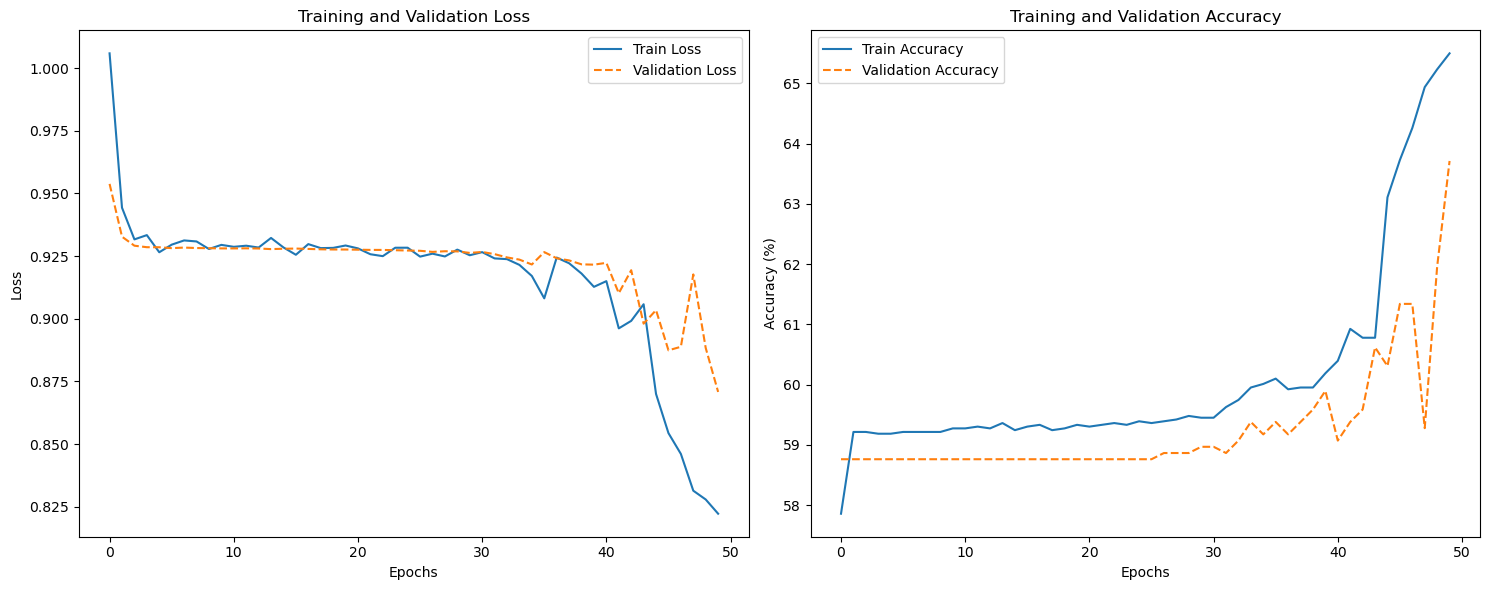

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss', linestyle='--')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

axes[1].plot(train_accs, label='Train Accuracy')
axes[1].plot(val_accs, label='Validation Accuracy', linestyle='--')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [20]:
_, val_acc = evaluate(model, val_loader, criterion, device)
_, test_acc = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print("Val acc: ", val_acc)
print("Test acc: ", test_acc)

Evaluation on val/test dataset
Val acc:  63.71134020618557
Test acc:  64.12371134020619
